In [116]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Flakify Results

In [98]:
flakify_flaky_test_predict = pd.read_csv('./results/flakify/flaky_per_test_predict_results.csv')
print('Total Number of test cases:',flakify_flaky_test_predict.shape[0])
print('Number of test cases that flakify incorrectly predicted:', flakify_flaky_test_predict.loc[flakify_flaky_test_predict['flaky'] != flakify_flaky_test_predict['predict']].shape[0])
flakify_flaky_test_predict.head()

Total Number of test cases: 46221
Number of test cases that flakify incorrectly predicted: 432


,Unnamed: 0,project,class,test_name,final_code,flaky,predict
0,0,oozie,TestCoordSubmitXCommand,testSubmitReservedVars,/**\n * Don't include controls in XML.\n *\n *...,1,1
1,1,oozie,TestAuthFilterAuthOozieClient,testClientWithAnonymous,public void testClientWithAnonymous() throws E...,1,0
2,2,oozie,TestBulkMonitorJPAExecutor,testJavaNoRecords,public void testJavaNoRecords() throws Excepti...,1,1
3,3,oozie,TestLiteWorkflowStoreService,testRetry,public void testRetry() throws Exception {\n ...,1,0
4,4,oozie,TestPurgeXCommand,testPurgeWFWithSubWF3,/**\n * Test : The subworkflow should get purg...,1,1


In [ ]:
# How many test cases detected in each project
flakify_flaky_test_predict.groupby(by='project').count()

,Unnamed: 0,class,test_name,final_code,flaky,predict
project,,,,,,
achilles,75,75,75,75,75,75
ambari,13,13,13,13,13,13
assertj-core,12024,12024,12024,12024,12024,12024
commons-exec,124,124,124,124,124,124
dropwizard,1730,1730,1730,1730,1730,1730
hadoop,4178,4178,4178,4178,4178,4178
hbase,529,529,529,529,529,529
hector,20,20,20,20,20,20
httpcore,1413,1413,1413,1413,1413,1413


In [99]:
# Generate Accuracy, Precision, Recall, F1 score for each project.
percentage = "{:.0%}".format
def get_evaluation_scores(tn, fp, fn, tp):
    if(tp == 0):
        accuracy = (tp+tn)/(tn+fp+fn+tp)
        Precision = 0
        Recall = 0
        F1 = 0
    else:
        accuracy = (tp+tn)/(tn+fp+fn+tp)
        Precision = tp/(tp+fp)
        Recall = tp/(tp+fn)
        F1 = 2*((Precision*Recall)/(Precision+Recall))
    return percentage(accuracy), percentage(F1), percentage(Precision), percentage(Recall)

result = pd.DataFrame(columns = ['project_name','Accuracy','F1', 'Precision', 'Recall', 'TN', 'FP', 'FN', 'TP'])
for project in flakify_flaky_test_predict['project'].unique():
    data = flakify_flaky_test_predict.loc[flakify_flaky_test_predict['project']==project]
    target = data['flaky']
    preds = data['predict']
    TN, FP, FN, TP = confusion_matrix(target, preds, labels=[0, 1]).ravel()
    accuracy, F1, Precision, Recall = get_evaluation_scores(TN, FP, FN, TP)
    result = result.append(pd.Series([project,accuracy, F1, Precision, Recall, TN, FP, FN, TP], index=result.columns), ignore_index=True)
# result.to_csv('./results/flakify/flakify_per_project_result.csv',  index=False)
result

,project_name,Accuracy,F1,Precision,Recall,TN,FP,FN,TP
0,oozie,75%,76%,100%,62%,415,2,304,488
1,hadoop,99%,96%,95%,98%,3838,17,7,316
2,jimfs,99%,75%,60%,100%,562,6,0,9
3,hbase,99%,96%,95%,97%,454,4,2,69
4,jackrabbit-oak,100%,50%,35%,88%,11483,13,1,7
5,achilles,100%,100%,100%,100%,8,0,0,67
6,orbit,100%,100%,100%,100%,0,0,0,8
7,okhttp,100%,100%,100%,100%,0,0,0,66
8,togglz,95%,50%,33%,100%,447,22,0,11
9,logback,100%,80%,67%,100%,678,1,0,2


# FlakeFlagger Results

In [100]:
flakeflagger_results = pd.read_csv('./results/flakeflagger/only_flakeflagger_classification_result/using_cross_validation/IG_0.0/prediction_result_by_project.csv')
flakeflagger_results = flakeflagger_results[['project', 'Precision', 'Recall', 'F1', 'TP', 'FN', 'FP', 'TN']]
flakeflagger_results['Accuracy'] = flakeflagger_results.apply(lambda row: percentage((row.TN + row.TP)/(row.TN+row.TP+row.FN+row.FP)), axis=1)
flakeflagger_results

,project,Precision,Recall,F1,TP,FN,FP,TN,Accuracy
0,ambari,0%,0%,0%,0,4,0,684,99%
1,hadoop,56%,81%,66%,180,43,141,1616,91%
2,hbase,77%,91%,84%,84,8,25,658,96%
3,hector,0%,0%,0%,0,4,0,124,97%
4,jackrabbit-oak,0%,0%,0%,0,4,1,6673,100%
5,logback,31%,36%,33%,4,7,9,860,98%
6,ninja,84%,79%,81%,26,7,5,310,97%
7,oryx,92%,83%,87%,24,5,2,262,98%
8,wro4j,0%,0%,0%,0,15,1,1049,98%
9,zxing,0%,0%,0%,0,2,0,338,99%


<BarContainer object of 21 artists>

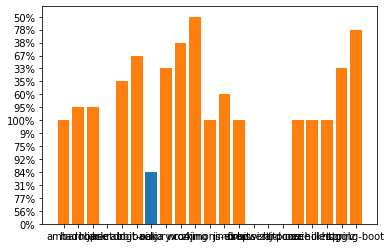

In [124]:
plt.bar(flakeflagger_results['project'], flakeflagger_results['Precision'])
plt.bar(result['project_name'], result['Precision'])


# Per Test Result Analysis

In [101]:
flakeflagger_per_test = pd.read_csv('./results/flakeflagger/only_flakeflagger_classification_result/using_cross_validation/IG_0.0/prediction_result_per_test.csv')
flakify_per_test = pd.read_csv('./results/flakify/flaky_per_test_predict_results.csv', index_col=0)

In [102]:
flakeflagger_per_test = flakeflagger_per_test[['test_name', 'Matrix_label']]
print(flakeflagger_per_test.shape)
flakeflagger_per_test.head()

(630, 2)


,test_name,Matrix_label
0,org.apache.ambari.server.agent.TestActionQueue...,FN
1,org.apache.hadoop.io.TestWritableName.testAddName,FN
2,org.apache.hadoop.fs.TestTrash.testTrashEmptier,FN
3,org.apache.hadoop.security.TestDoAsEffectiveUs...,TP
4,org.apache.hadoop.hdfs.web.TestWebHdfsFileSyst...,FP


In [ ]:
print(flakify_per_test.shape)
flakify_per_test.head()

(46221, 6)


,project,class,test_name,final_code,flaky,predict
0,oozie,TestCoordSubmitXCommand,testSubmitReservedVars,/**\n * Don't include controls in XML.\n *\n *...,1,1
1,oozie,TestAuthFilterAuthOozieClient,testClientWithAnonymous,public void testClientWithAnonymous() throws E...,1,0
2,oozie,TestBulkMonitorJPAExecutor,testJavaNoRecords,public void testJavaNoRecords() throws Excepti...,1,1
3,oozie,TestLiteWorkflowStoreService,testRetry,public void testRetry() throws Exception {\n ...,1,0
4,oozie,TestPurgeXCommand,testPurgeWFWithSubWF3,/**\n * Test : The subworkflow should get purg...,1,1


In [112]:
from collections import defaultdict
unique_tests = set()
tests = defaultdict(lambda :defaultdict(list))
for index, test in flakeflagger_per_test.iterrows():
  test_name, label = test['test_name'], test['Matrix_label']
  splits = test_name.split('.')
  classname, testname = splits[-2], splits[-1]
  tests[(classname, testname)]['flakeflagger'].append((classname, testname, label))

for index, test in flakify_per_test.iterrows():
  classname, testname, flaky, predict = test['class'], test['test_name'], test['flaky'], test['predict']
  if (classname, testname) not in tests: continue
  tests[(classname, testname)]['flakify'].append((project, classname, testname, flaky, predict))


In [114]:
both_detected_cnt = 0
flakeflagger_cnt = 0
flakify_cnt = 0

flaky_tests_only_by_flakeflagger = set()
flaky_tests_only_by_flakify = set()
flaky_tests_only_by_both = set()

for (classname, testname), data in tests.items():
  flakeflagger = data['flakeflagger']
  flakify = data['flakify']
  if len(flakeflagger) == 0 and len(flakify) != 0:
    flakify_cnt += 1
  elif len(flakeflagger) != 0 and len(flakify) == 0:
    flakeflagger_cnt += 1
  elif len(flakeflagger) != 0 and len(flakify) != 0:
    both_detected_cnt += 1
    # flaky tests
    if any([(test[2] in ['FN', 'TP']) for test in flakeflagger]):
      ff_d = any([(test[2] == 'TP') for test in flakeflagger])
      if ff_d:
        for test in flakeflagger:
          if test[2] == 'TP':
            detected = test
            break

      fky_d = any([(test[2] == 1 and test[3] == 1) for test in flakify])
      if fky_d:
        for test in flakify:
          if test[2] == 1 and test[3] == 1:
            detected = test
            break

      if ff_d and not fky_d:
        flaky_tests_only_by_flakeflagger.add(detected)
      
      if fky_d and not ff_d:
        flaky_tests_only_by_flakify.add(detected)
      
      if ff_d and fky_d:
        flaky_tests_only_by_both.add(detected)

print("Number of tests detected by flakeflagger:", flakeflagger_cnt)
print("Number of tests detected by flakify:", flakify_cnt)
print("Number of tests detected by both:", both_detected_cnt)

print("Number of flaky tests detected by flakeflagger: ", len(flaky_tests_only_by_flakeflagger))
print("Number of flaky tests detected by flakify: ", len(flaky_tests_only_by_flakify))
print("Number of flaky tests detected by both: ", len(flaky_tests_only_by_both))

Number of tests detected by flakeflagger: 280
Number of tests detected by flakify: 0
Number of tests detected by both: 347
Number of flaky tests detected by flakeflagger:  252
Number of flaky tests detected by flakify:  0
Number of flaky tests detected by both:  0
